In [16]:
%matplotlib inline

## Software Comparison Project with NIDM-Results

This notebook demonstates how to reproduce the results presented in the Software Comparison Project publication using NIDM-Results packs available on [NeuroVault (ZJNRUHIM)](http://neurovault.org/collections/ZJNRUHIM/).


In [1]:
import os
from rdflib.graph import Graph
from rdflib.term import URIRef
from subprocess import check_call
from nidmresults.graph import Graph
from nidmresults.objects.constants import SCR_FSL, SCR_SPM
import collections
import glob
import zipfile
import json
from urllib2 import urlopen, URLError, HTTPError
from urllib2 import Request
from nilearn import plotting

### Download the NIDM-Results packs from NeuroVault

 - Query NeuroVault's API to retreive all NIDM packs in collection ZJNRUHIM
 - Download and save the packs in sub-folder `input/data` 

In [8]:
nv_collections = (
    'ZJNRUHIM',
    'UMMSIQGP'
)

for nv_collection in nv_collections:
    print(nv_collection)
    request = Request('http://neurovault.org/api/collections/' + nv_collection + '/nidm_results/?limit=184&format=json')
    response = urlopen(request)
    elevations = response.read()
    data = json.loads(elevations)

    pwd = os.path.dirname(os.path.realpath('__file__'))
    input_dir = os.path.join(pwd, "input")
    data_dir = os.path.join(input_dir, "data")

    if not os.path.isdir(data_dir):
        if not os.path.isdir(input_dir):
            os.makedirs(input_dir)
        os.makedirs(data_dir)


    for nidm_result in data["results"]:
        url = nidm_result["zip_file"]
        study_name = nidm_result["name"]

        localzip = os.path.join(data_dir, study_name + ".zip")
        localzip_rel = localzip.replace(pwd, '.')
        if not os.path.isfile(localzip):
            # Copy .nidm.zip export locally in a the data directory
            try:
                f = urlopen(url)
                print("downloading " + url + " at " + localzip_rel)
                with open(localzip, "wb") as local_file:
                    local_file.write(f.read())
            except HTTPError, e:
                raise Exception(["HTTP Error:" + e.code + url])
            except URLError, e:
                raise Exception(["URL Error:" + e.reason + url])
        else:
            print(url + " already downloaded at " + localzip_rel)

ZJNRUHIM
http://neurovault.org/collections/ZJNRUHIM/spm_0001.nidm.zip already downloaded at ./input/data/spm_0001.nidm.zip
UMMSIQGP
downloading http://neurovault.org/collections/UMMSIQGP/group.gfeat.nidm.zip at ./input/data/group.gfeat.nidm.zip


In [66]:
import zipfile
import shutil

spm_pack = open('./input/data/spm_0001.nidm.zip', 'rb')
z = zipfile.ZipFile(spm_pack)
z.extract('ExcursionSet.nii.gz', './input/data/')

spm_exc_set_file = './input/data/spm_exc_set.nii.gz'
shutil.move('./input/data/ExcursionSet.nii.gz', spm_exc_set_file)

fsl_pack = open('./input/data/group.gfeat.nidm.zip', 'rb')
z = zipfile.ZipFile(fsl_pack)
z.extract('ExcursionSet_T001.nii.gz', './input/data/')
z.extract('ExcursionSet_T002.nii.gz', './input/data/')

fsl_exc_set_file = './input/data/fsl_exc_set.nii.gz'
shutil.move('./input/data/ExcursionSet_T001.nii.gz', fsl_exc_set_file)

fsl_exc_set_file_neg = './input/data/fsl_exc_set_neg.nii.gz'
shutil.move('./input/data/ExcursionSet_T002.nii.gz', fsl_exc_set_file_neg)

exc_sets = dict()
exc_sets["spm"] = (spm_exc_set_file, fsl_exc_set_file_neg)
exc_sets["fsl"] = (fsl_exc_set_file, fsl_exc_set_file_neg)

/Users/cmaumet/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4144: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


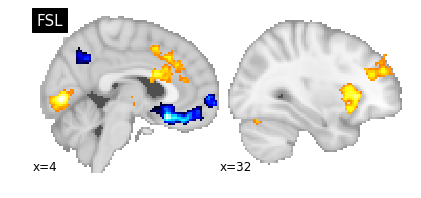

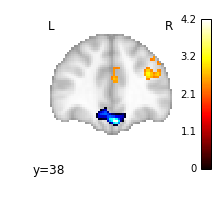

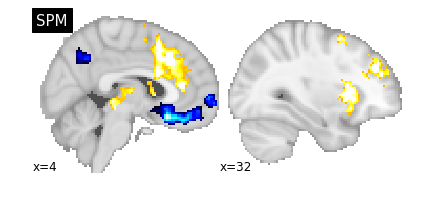

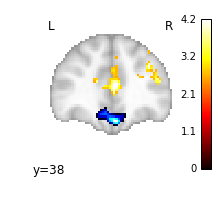

In [70]:
from nilearn import plotting


for soft, (exc_set_file, exc_set_file_neg) in exc_sets.items():
    display = plotting.plot_stat_map(exc_set_file, display_mode='x', cut_coords=[4, 32], draw_cross=False, colorbar=False, 
                           title=soft.upper(), threshold=0.000001, vmax=4.2)
    display.add_overlay(exc_set_file_neg, cmap=plotting.cm.black_blue)
    display = plotting.plot_stat_map(exc_set_file, cut_coords=[38], draw_cross=False, display_mode='y', 
                           threshold=0.000001, colorbar=True, vmax=4.2)
    display.add_overlay(exc_set_file_neg, cmap=plotting.cm.black_blue)

plotting.show()

In [9]:
studies = glob.glob(os.path.join(data_dir, '*.nidm.zip'))
local_spm_canonical_dir = '/Users/maullz/Software/spm12/canonical/'
studies = studies[0:1]
print(studies)

for nidm_file in studies:
    archive = zipfile.ZipFile(nidm_file,'r')
    excursion_set = archive.read('ExcursionSet.nii.gz')
    canonical_anat = glob.glob(os.path.join(local_spm_canonical_dir,'avg152T1.nii'))[0]
    plotting.plot_stat_map(excursion_set, canonical_anat, title=(nidm_file + "_excursion_set_map"))
    


['/Users/cmaumet/Projects/Data_sharing/dev/Software_Comparison/input/data/group.gfeat.nidm.zip']


KeyError: "There is no item named 'ExcursionSet.nii.gz' in the archive"